CUDA is not available.  Training on CPU ...
102
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=

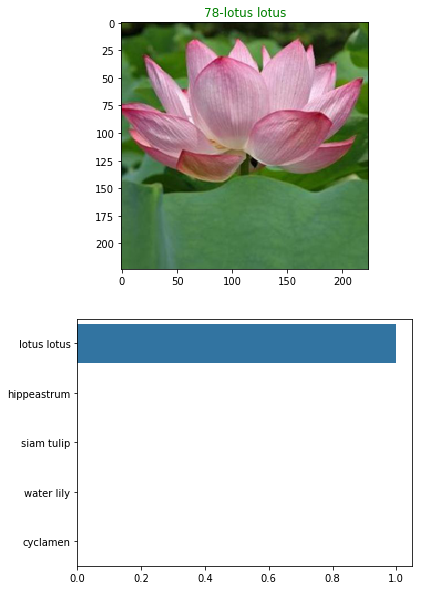

[9.99997638e-01 1.68775896e-06 4.44718055e-07 9.09543386e-08
 7.97249621e-08]
['78', '39', '73', '88', '91']
['lotus lotus', 'siam tulip', 'water lily', 'cyclamen', 'hippeastrum']


In [1]:
###################################LoadAllTheSHit

import torch
import os
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import json
import seaborn as sns
from PIL import Image
import copy
from collections import OrderedDict
from torch.optim import lr_scheduler
from torch.autograd import Variable
import operator

#image_path = 'C:/PyTorch/flower_data/test/78/image_01874.jpg'

# check if CUDA is available
train_on_gpu = False

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU.....Left, Square, Square, Square, Left ')

#########################################


# Load the pretrained model from pytorch
model = models.vgg16(pretrained=False)
# Freeze training for all "features" layers
for param in model.features.parameters():
    param.requires_grad = False
n_inputs = model.classifier[6].in_features
#print(model.classifier[6].in_features) 
#print(model.classifier[6].out_features) 

# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, 102)
model.classifier[6] = last_layer
# if GPU is available, move the model to GPU
if train_on_gpu:
    model.cuda()
# check to see that your last layer produces the expected number of outputs
print(model.classifier[6].out_features)
#print(model)
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()
# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(model.parameters(), lr=0.0005)

# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath, map_location='cpu')

    model.load_state_dict(checkpoint['state_dict'], strict=False)
    #model.load_state_dict(torch.load(filepath, map_location='cpu'), strict=False)
    
    model.class_to_idx = checkpoint['class_to_idx']

    return model


#model = load_checkpoint('BAMFFlowerPowerTrue.pth')
model = load_checkpoint('BAMFFlowerPowerRevDv2True.pth')

print(model)
print(model.class_to_idx)

#######################################################


with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
class_names = model.class_to_idx

sortedclasses = sorted(cat_to_name.items())
print(sortedclasses[0])

#########################

def process_image(image_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns an Numpy array
    '''
    # If you used something other than 224x224 cropped images, set the correct size here
    #image_size = 224
    # Values you used for normalizing the images. Default here are for 
    # pretrained models from torchvision.
    #norm_mean = [0.485, 0.456, 0.406]
    #norm_std = [0.229, 0.224, 0.225]
    # Open the image
    img = Image.open(image_path)

    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((50000, 256))
    else:
        img.thumbnail((256, 50000))

    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin, top_margin))
    
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #Required mean
    std = np.array([0.229, 0.224, 0.225]) #Required std
    img = (img - mean)/std
    
    # Move color channels PyTorch expects the color channel to be the first dimension
    #img = img.numpy().transpose((2, 0, 1))
    img = img.transpose((2, 0, 1))
    
    return img
########################################################
   
## doneabove

def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

##################################################

def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    # Process image
    img = process_image(image_path)    
    # Numpy -> Tensor
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Add batch of size 1 to image
    model_input = image_tensor.unsqueeze(0)    
    # Probs
    probs = torch.exp(model.forward(model_input))    
    # Top probs
    top_probs, top_labs = probs.topk(topk)
    top_probs_sum = np.sum(top_probs.detach().numpy())
    top_probs = top_probs.detach().numpy().tolist()[0] 
    top_labs = top_labs.detach().numpy().tolist()[0]    
    # Convert indices to classes
    idx_to_class = {val: key for key, val in model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labs]
    top_flowers = [cat_to_name[idx_to_class[lab]] for lab in top_labs]
    
    return top_probs/top_probs_sum, top_labels

#######################################

# TODO: Display an image along with the top 5 classes
def plot_solution(image_path, model):
    # Set up plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)

    # Set up title
    flower_num = image_path.split('/')[4]
    flowerClass = cat_to_name[flower_num]
    #print(flower_num)
    #print(flowerClass)
    # Plot flower
    img = process_image(image_path)
    #imshow(img, ax, title = title_);
    imshow(img, ax);
    #ax.set_title(flowerClass, color=("green"))


    # Make prediction
    probs, labs = predict(image_path, model) 
    #print(labs[0])
    #print(flower_num)
    
    ax.set_title("{}-{}".format(flower_num, flowerClass), 
                 color=("green" if flower_num==labs[0] else "red"))
    
    idx_to_classd2 = {val: key for key, val in model.class_to_idx.items()}
    flowers = [cat_to_name[labB] for labB in labs]

    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    plt.show()
    
########################################
plot_solution(image_path, model)
probs, classes = predict(image_path, model.cpu())

idx_to_classd1 = {val: key for key, val in model.class_to_idx.items()}
flowers = [cat_to_name[labB] for labB in classes]

print(probs)
print(classes)
print(flowers)
#print(probs.sum())
